<a href="https://colab.research.google.com/github/Lakshman511/MSLID/blob/master/ColabNotebooks/Final_Model_with_Augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install --pre torchaudio -f https://download.pytorch.org/whl/nightly/torch_nightly.html
#!pip install torchaudio
#!pip install git+git://github.com/pytorch/audio

Looking in links: https://download.pytorch.org/whl/nightly/torch_nightly.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from zipfile import ZipFile
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
torch.cuda.is_available()

True

In [ ]:
with ZipFile('/content/drive/My Drive/Languages.zip', mode='r') as input:
  input.extractall(".") 

In [ ]:
import os
import random
import torchaudio

def prepareData(root, classes, datatype="train", duration=2, overlap=0.25, file_save="file.txt"):
    dataset = []
    for L in classes.keys():
        if datatype == "train":
            path = root + "/" + L + "/" + L + "_Train/"
        else:
            path = root + "/" + L + "/" + L + "_Test/"
        tempdata = [(path+f, classes[L]) for f in os.listdir(path)]

        for x in tempdata:
            waveform, samplerate = torchaudio.load(x[0])
            wave_size = waveform.size()[1]
            samplesize = int(samplerate * duration)
            start = 0
            while True:
                finish = start + samplesize
                if finish < wave_size:
                    dataset.append((x[0], start, finish, x[1]))
                else:
                    break
                start = start + int(samplesize * (1 - overlap))
        
    random.shuffle(dataset)

    #create a text file
    with open(file_save, "w") as ft:
        ft.write("audiofile, start, finish, label" + "\n")
        for sample in dataset:
            ft.write(str(sample)[1:-1] + "\n")
    

In [ ]:
classes = {"Tamil" : 1, "Telugu" : 2, "Bengali" : 3, "Gujarathi" : 0 }
prepareData("/content/Languages", classes, datatype="train", duration=4, overlap=0.25, file_save="train_d2_o25.txt")
#preparing Test data
prepareData("/content/Languages", classes, datatype="test", duration=4, overlap=0.25, file_save="test_d2_o25.txt")
print("Dataset was written to the specified files successfully")



Dataset was written to the specified files successfully


In [ ]:
import torch
import torchaudio
import torch.nn as nn
import pandas as pd
import numpy as np

class LogMelSpec(nn.Module):
    def __init__(self, sample_rate = 8000, n_mels=128, win_length=160, hop_length=80):
        super(LogMelSpec, self).__init__()
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels, win_length=win_length, hop_length=hop_length)

    def forward(self, x):
         x = self.transform(x)   # gets melspectrogram
         x = np.log(x + 1e-14)    #smoothing to avoid infinity
         return x


# add time stretch and freq augmentations
class SpecAugment(nn.Module):
    def __init__(self, rate, strategy=3, freq_mask=10, time_mask=30):
        super(SpecAugment, self).__init__()
        self.rate = rate
        
        self.specaug1 = nn.Sequential(
            torchaudio.transforms.FrequencyMasking(freq_mask),
            torchaudio.transforms.TimeMasking(time_mask)
        )

        self.specaug2 = nn.Sequential(
            torchaudio.transforms.FrequencyMasking(freq_mask),
            torchaudio.transforms.TimeMasking(time_mask),
            torchaudio.transforms.FrequencyMasking(freq_mask),
            torchaudio.transforms.TimeMasking(time_mask)
        )

        strategies = {1 : self.strategy1, 2 : self.strategy2, 3 : self.strategy3}
        self._forward = strategies[strategy]

    def forward(self, x):
        return self._forward(x)
        
    def strategy1(self, x):
        probability = torch.randn(1,1).item()
        if self.rate > probability:
            return self.specaug1(x)
        return x
        
    def strategy3(self, x):
        probability = torch.randn(1,1).item()
        if probability > 0.5:
            return self.strategy1(x)
        return self.strategy2(x)
        
    def strategy2(self, x):
        probability = torch.rand(1, 1).item()
        if self.rate > 0.5:
            return self.specaug2(x)
        return x




class AudioData(torch.utils.data.Dataset):
    parameters = {
        "sample_rate" : 8000,
        "n_feats" : 81,
        "rateof_aug" : 0.5,
        "aug_strategy" : 3,
        "time_mask" : 30,
        "freq_mask" : 10,
        
    }

    def __init__(self, datafile_path, sample_rate, n_feats, rateof_aug, aug_strategy, time_mask, freq_mask, valid=False, shuffle=True, log_ex=True):
        
        self.log_ex = log_ex

        
        if(type(datafile_path)==type("s")):
          print("Loaaa..ding data from ", datafile_path)
          self.data = pd.read_csv(datafile_path, delimiter=',')
        else:
          self.data = datafile_path

        if valid:
            self.audio_transforms = torch.nn.Sequential(
                LogMelSpec(sample_rate=sample_rate, n_mels=n_feats, win_length=160, hop_length=80)
                )
        else:
            self.audio_transforms = torch.nn.Sequential(
                LogMelSpec(sample_rate=sample_rate, n_mels=n_feats, win_length=160, hop_length=80),
                SpecAugment(rateof_aug, aug_strategy, time_mask, freq_mask) 
            )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.item()
        
        file_path = self.data.audiofile.iloc[index]
        waveform, _ = torchaudio.load(file_path[1:-1])
        label = self.data.iloc[index, 3]
        start = self.data.iloc[index, 1]
        finish = self.data.iloc[index, 2]
        waveform = waveform[: , start : finish]
        spectrogram = self.audio_transforms(waveform)
        #spec_len = spectrogram.shape[-1] // 2
        #label_len = 1
        return spectrogram, label
    
    def describe(self):
        return self.data.describe()

In [ ]:
train = AudioData("./train_d2_o25.txt", sample_rate=8000, n_feats=81, rateof_aug=0.5, aug_strategy=3, time_mask=30, freq_mask=10)
print(len(train))
test = AudioData("./test_d2_o25.txt", sample_rate=8000, n_feats=81, rateof_aug=0.5, aug_strategy=3, time_mask=30, freq_mask=10, valid=True)
print(len(test))


Loaaa..ding data from  ./train_d2_o25.txt
13744
Loaaa..ding data from  ./test_d2_o25.txt
3398


In [ ]:

classes = {"Tamil" : 1, "Telugu" : 2, "Bengali" : 3, "Gujarathi" : 0, "Hindi":4 , "Assame":5 }
#import dataset
batch_size = 32
cuda = torch.cuda.is_available()
print(cuda)
if cuda:
  torch.cuda.manual_seed(1)
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4) if cuda else dict(shuffle=True, batch_size=batch_size)
train_loader = DataLoader(train,  **dataloader_args)
test_loader = DataLoader(test, **dataloader_args)

True


In [ ]:
batch_size = 32
cuda = torch.cuda.is_available()
print(cuda)
if cuda:
  torch.cuda.manual_seed(1)
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4) if cuda else dict(shuffle=True, batch_size=batch_size)
train_loader = DataLoader(train,  **dataloader_args)
test_loader = DataLoader(test, **dataloader_args)

True


In [ ]:
print(type(train_loader))
print(len(train_loader.dataset))

torch.utils.data.dataloader.DataLoader
13744


In [ ]:


print(type(test_loader))
print(len(test_loader.dataset))

torch.utils.data.dataloader.DataLoader
3398


In [ ]:
sample = next(iter(train_loader))

In [ ]:
sample[0].size()

torch.Size([32, 1, 81, 401])

In [ ]:
sample = next(iter(test_loader))
sample[0].size()

torch.Size([32, 1, 81, 401])

In [ ]:
print(type(sample))
print(sample[0][0].size())
print(len(sample[0]))
print(sample[0][1].size())
print(len(sample[1]))
print(sample[1])

<class 'list'>
torch.Size([1, 81, 401])
32
torch.Size([1, 81, 401])
32
tensor([1, 1, 2, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 1, 3,
        0, 1, 3, 1, 1, 0, 0, 1])


In [ ]:
dropout_value = 0.06
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(5,5) # output_size = 12, RF = 6

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),

            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(2048),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(5,5) # output_size = 12, RF = 6

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=(3,3), padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3,3), padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22
        self.convblock11= nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock12= nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.convblock13= nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=6, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x=self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x=self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.pool1(x)
        x = self.convblock9(x)
        x=self.convblock10(x)
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.gap(x)
        x = self.convblock13(x)
        x = x.view(-1, 6)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda")# if use_cuda else "cpu")
print(device)
model = Net().to(device)

summary(model, input_size=(1, 81 , 81))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 81, 81]             288
       BatchNorm2d-2           [-1, 32, 81, 81]              64
           Dropout-3           [-1, 32, 81, 81]               0
              ReLU-4           [-1, 32, 81, 81]               0
            Conv2d-5           [-1, 64, 81, 81]          18,432
       BatchNorm2d-6           [-1, 64, 81, 81]             128
           Dropout-7           [-1, 64, 81, 81]               0
              ReLU-8           [-1, 64, 81, 81]               0
            Conv2d-9          [-1, 128, 81, 81]          73,728
      BatchNorm2d-10          [-1, 128, 81, 81]             256
          Dropout-11          [-1, 128, 81, 81]               0
             ReLU-12          [-1, 128, 81, 81]               0
           Conv2d-13          [-1, 256, 81, 81]         294,912
      BatchNorm2d-14          [-1,

In [ ]:
print(torch.__version__)
use_cuda

1.7.0.dev20200910+cu92


True

In [ ]:
from tqdm import tqdm
import numpy as np

class ModelTrain():
  def __init__(self):
    #to monitor training and test losses
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.preds={}
    # initialize tracker for minimum validation loss
    self.valid_loss_min = np.Inf # set initial "min" to infinity

  def train(self, model, device, train_loader, optimizer, epoch,scheduler,  L1lambda=None):
    model.train()    # prep model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)   # forward pass: compute predicted outputs by passing inputs to the model
      

      # Calculate loss
      loss = F.nll_loss(y_pred, target)
      
      #Implementing L1 regularization
      if L1lambda is not None:
        #l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        for param in model.parameters():
          #reg_loss += l1_crit(param)
          reg_loss += torch.sum(param.abs())
        loss += L1lambda * reg_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])


  ####VAlidate the model ####
  def test(self, model, device, test_loader, filename):
    #valid_loss_min = np.Inf
    model.eval()  # prep model for evaluation
    test_loss = 0
    correct = 0
    self.preds={}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += criterion(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            #print(target,pred)
            for i in range(len(target)):
              #print(target[i],pred[i])
              if (target[i].item() not in self.preds):
                self.preds[target[i].item()]=[pred[i][0].item()]
              else:
                self.preds[target[i].item()].append(pred[i][0].item())
    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    self.test_acc.append(100. * correct / len(test_loader.dataset))

    # save model if validation loss has decreased
    if test_loss <= self.valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        self.valid_loss_min,
        test_loss))
        torch.save(model.state_dict(), filename)
        self.valid_loss_min = test_loss

In [ ]:
#from torch.optim.lr_scheduler import StepLR
#torch.cuda.empty_cache()

from torch.optim.lr_scheduler import OneCycleLR
import gc
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0725, steps_per_epoch=len(train_loader), epochs=15)

#first model
#without L1 and L2 regularization
model00 = ModelTrain()
EPOCHS = 15
for epoch in range(EPOCHS):
    gc.collect()
    print("EPOCH:", epoch)
    model00.train(model, device, train_loader, optimizer, epoch, scheduler)
    model00.test(model, device, test_loader, "/content/drive/My Drive/LM6withAug.pt")

  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2386053502559662 Batch_id=429 Accuracy=74.59: 100%|██████████| 430/430 [03:58<00:00,  1.81it/s]



Test set: Average loss: 1.0175, Accuracy: 2129/3398 (62.65%)

Validation loss decreased (inf --> 1.017465).  Saving model ...


  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.31698644161224365 Batch_id=429 Accuracy=84.82: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 1.1289, Accuracy: 2136/3398 (62.86%)

EPOCH: 2


Loss=0.46990150213241577 Batch_id=429 Accuracy=89.08: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]



Test set: Average loss: 0.8060, Accuracy: 2503/3398 (73.66%)

Validation loss decreased (1.017465 --> 0.805974).  Saving model ...


  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH: 3


Loss=0.1685934066772461 Batch_id=429 Accuracy=91.87: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.8099, Accuracy: 2553/3398 (75.13%)

EPOCH: 4


Loss=0.6776517629623413 Batch_id=429 Accuracy=94.11: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 1.5426, Accuracy: 2104/3398 (61.92%)

EPOCH: 5


Loss=0.025194473564624786 Batch_id=429 Accuracy=95.04: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]



Test set: Average loss: 0.6609, Accuracy: 2719/3398 (80.02%)

Validation loss decreased (0.805974 --> 0.660865).  Saving model ...


  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH: 6


Loss=0.2183602899312973 Batch_id=429 Accuracy=96.11: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.9435, Accuracy: 2458/3398 (72.34%)

EPOCH: 7


Loss=0.007821476086974144 Batch_id=429 Accuracy=97.08: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.7718, Accuracy: 2519/3398 (74.13%)

EPOCH: 8


Loss=0.005161566659808159 Batch_id=429 Accuracy=97.68: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]



Test set: Average loss: 0.3446, Accuracy: 3018/3398 (88.82%)

Validation loss decreased (0.660865 --> 0.344637).  Saving model ...


  0%|          | 0/430 [00:00<?, ?it/s]

EPOCH: 9


Loss=0.20284363627433777 Batch_id=429 Accuracy=98.27: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.5995, Accuracy: 2731/3398 (80.37%)

EPOCH: 10


Loss=0.02948042005300522 Batch_id=429 Accuracy=98.37: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.4939, Accuracy: 2870/3398 (84.46%)

EPOCH: 11


Loss=0.022730883210897446 Batch_id=429 Accuracy=99.08: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.5260, Accuracy: 2846/3398 (83.76%)

EPOCH: 12


Loss=0.5452890396118164 Batch_id=429 Accuracy=99.23: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.4380, Accuracy: 2932/3398 (86.29%)

EPOCH: 13


Loss=0.0071114166639745235 Batch_id=429 Accuracy=99.40: 100%|██████████| 430/430 [03:58<00:00,  1.80it/s]
  0%|          | 0/430 [00:00<?, ?it/s]


Test set: Average loss: 0.5737, Accuracy: 2814/3398 (82.81%)

EPOCH: 14


Loss=0.28573524951934814 Batch_id=429 Accuracy=99.45: 100%|██████████| 430/430 [03:58<00:00,  1.81it/s]



Test set: Average loss: 0.5605, Accuracy: 2825/3398 (83.14%)



In [ ]:
for i in range(4):
  #print(i,(model00.preds[i].count(i)/len(model00.preds[i]))*100)
  for j in range(4):
    print(i,j,model00.preds[i].count(j))
  print()

0 0 1151
0 1 186
0 2 76
0 3 0

1 0 18
1 1 755
1 2 163
1 3 31

2 0 9
2 1 24
2 2 475
2 3 0

3 0 2
3 1 2
3 2 62
3 3 444



In [ ]:
for i in range(4):
  print(i,(model00.preds[i].count(i)/len(model00.preds[i]))*100)
  '''for j in range(4):
    print(i,j,model00.preds[i].count(j))'''
  print()

0 81.45789101203114

1 78.07652533609101

2 93.50393700787401

3 87.05882352941177



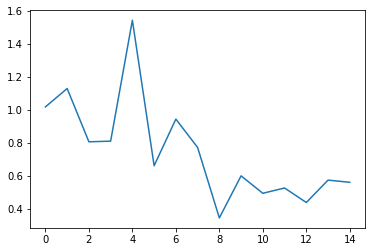

In [ ]:
plt.plot(model00.test_losses)

<class 'torch.Tensor'>
Shape of spectrogram: torch.Size([1, 128, 241])


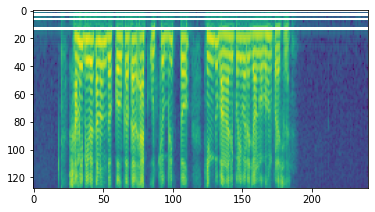

In [ ]:
wave_form, sample_rate = torchaudio.load('./Languages/Bengali/Bengali_Train/Bengali1764.wav')

specgram = torchaudio.transforms.MelSpectrogram(win_length=256,hop_length=256)(wave_form[0:3200])
print(type(specgram))

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy())

In [ ]:
parameters = {
        "sample_rate" : 8000,
        "n_feats" : 81,
        "rateof_aug" : 0.5,
        "aug_strategy" : 3,
        "time_mask" : 30,
        "freq_mask" : 10,
        
    }

In [ ]:
audio_transforms = torch.nn.Sequential(
                LogMelSpec(sample_rate=8000, n_mels=128, win_length=256, hop_length=256),
                SpecAugment(0.5, 3,30, 10) 
            )

<class 'torch.Tensor'>
Shape of spectrogram: torch.Size([1, 128, 241])


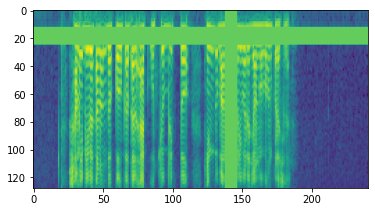

In [ ]:
wave_form, sample_rate = torchaudio.load('./Languages/Bengali/Bengali_Train/Bengali1764.wav')

specgram = audio_transforms(wave_form[0:3200])
print(type(specgram))

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram[0,:,:].detach().numpy())